### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("darkgrid")
from stop_words import get_stop_words
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from gensim.models import KeyedVectors
from sklearn.base import TransformerMixin 
from sklearn.base import BaseEstimator
from sklearn.ensemble import VotingClassifier

### Side functions

In [49]:
def cleanString(sentence):
    
    """Return string
    
    Remove punctuation from sentence
    """
    
    return "".join(" " if p in punctuation else p for p in sentence.strip(punctuation))


def cleanStopWords(sentence, stopWords):
    
    """Return string
    
    Remove stopWords from sentence
    """
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in sentence.split() if word.lower() not in stopWords]
    # joining the list of words with space separator
    return " ".join(text)


def get_top_n_words(corpus, n=None):
    
    """Return a list
    
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    
    # create a count vectorizer object
    vec = CountVectorizer()
    # fit and transform the data using vec
    bag_of_words = vec.fit_transform(corpus)
    # sum each word occurrence
    sum_words = bag_of_words.sum(axis=0)
    # number of words in the corpus 
    total = sum_words.sum(axis=1)[0,0]
    # create list of words frequency
    words_freq = [(word, sum_words[0, idx] / total) for word, idx in vec.vocabulary_.items()]
    # sort the list
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_word_freq(words, freq, title, n=30, adjx=0, adjy=0, c="darkorange"):
    
    """Plot words frequency
    words : list : list of words to plot
    freq  : list : frequency of each word in words
    title : string : plot title
    n : int : number of words (len(words))
    adj: int: annotation adjustement
    """
    
    plt.figure(figsize=(10, 8))
    ax = sb.pointplot(x=list(range(1,n+1)), y=freq, color=c)
    #For each point, we add the word as annotation
    for line in range(n):
         ax.text(line+adjx, freq[line]+adjy, words[line], \
                 horizontalalignment='left', size='large', rotation = 50)
    ax.set(xlabel='Word index', ylabel='Word frequency', title=title)
    
    
def tokenizer_stemmer(sentence, stemmer=FrenchStemmer()):
        
        """Return a list
        sentence: text to tokenize and stemmer
        stemmer: stemming algorithm
    
        Preprocess the sentence (lowercase, remove punctuation and clean words, tokenize)
        Return stemmed words
        """
        #remove punctuation
        text_punt = cleanString(sentence)
        #remove stopWords
        text_punt_sw = cleanStopWords(text_punt, stopWords)
        # get tokens (words)
        tokens = word_tokenize(text_punt_sw)
        # stem the token using SnowballStemmer
        stems = []
        for item in tokens:
                stems.append(stemmer.stem(item))
        return stems
    
    
def plot_param_effect(grid, param, title):
    
    """Plot train and validation scores for param
    
    param: string: parameter to analyse
    title: string: title
    
    """
    ax2 = sb.lineplot(x=grid.cv_results_[param].data.tolist(), y=grid.cv_results_["mean_train_score"], label="train")
    ax1 = sb.lineplot(x=grid.cv_results_[param].data.tolist(), y=grid.cv_results_["mean_test_score"], label = 'validation')
    plt.legend()
    ax1.set(xlabel='parameter values', ylabel='Score', title=title)
    plt.savefig("images/"+title+".png")
    
    
def plot_confusion_matrix(y_test, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    title = title

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = classes

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5)
    plt.ylim(len(np.unique(y_test))-0.5, -0.5) 
    return ax


    np.set_printoptions(precision=2)

    # Plot matrice de confusion
    plot_confusion_matrix(df_clustering["True label"], df_clustering["Predicted labels"],
                      classes=classes)

    plt.show()
    
    
    
def make_feature_vec2(sentences, model, num_features=52):
    
    """ Calculates the average of all the vectorized word for sentences.
    
    Input:
    - sentences: pd.Series: the sentences to be converted to vectors
    - model: the word2vec pre trained model
    - num_features: vectors size (by default 52)
    """
    
    print("word2vec transformation ...")
    output = pd.Series([])
    index = 0
    for sentence in sentences:
        #remove punctuation
        text_punt = cleanString(sentence)
        #remove stopWords
        text_punt_sw = cleanStopWords(text_punt, stopWords)
        # get tokens (words)
        tokens = word_tokenize(text_punt_sw)
        # create a list of vectors for each word in one sentence
        vectorized = [model[word] if word in model else np.zeros(num_features) for word in tokens]
        # number of words (transformed in vectors in the sentence)
        length = len(vectorized)
        # average on vectorized elements
        summed = np.sum(vectorized, axis = 0) # vector sum
        if length == 0:                       # case for empty sentence after cleaning
            feature_vec = np.zeros((num_features),dtype="float32")
        else:
            feature_vec = np.divide(summed, length)
        feature_vec = pd.Series([feature_vec], index=[index])    #vector to add to the series
        index += 1  #increment the index
        output = output.append(feature_vec)   # add the vector to the ouput
    print("word2vec transformation finish")
    return np.vstack(output) 



#Custom Word2vec Transformer
#Convert texts to vectors  
class word2vec_transformer(BaseEstimator, TransformerMixin):
   
    def __init__(self, model, dim):
        self.model = model
        self.dim = dim
        
    
    def transform(self, X, *_):
        return make_feature_vec2(X, self.model, self.dim)
    
    
    def fit(self, *_):
        return self
    
    
# function used to do the models combination
def voters(x):
    
    """ Return the correct label
    
    Input:
    - x: int : can be 0, 1, 2: sum of predciton for one sentence
    """
    
    if x == 0 or x==1:
        return 0
    else:
        return 1

### I- Data loading

In [3]:
# load sentences from Data folder
sentences = pd.read_pickle("Data/sentences.pkl")
# load labels from Data folder
labels = pd.read_pickle("Data/labels.pkl")

In [4]:
# convert sentences to pandas dataframe
data = pd.DataFrame(({'sentences':sentences, 'labels':labels})) 

In [5]:
data.head()

,sentences,labels
0,J'aurai l'occasion de dire aux Français commen...,C
1,Il est nécessaire.,C
2,"Dans votre coeur et dans votre vie, la confian...",C
3,Pour conduire ce débat dans un esprit de vérit...,C
4,La France et l'Europe construiront ainsi un av...,C


### II- Data preprocessing

In this section, we will clean the data.

In [6]:
# load list of french stopwords
stopWords = get_stop_words('french')
# Remove punctuation and set to lowercase
data['clean_sentences'] = data['sentences'].apply(lambda s: cleanString(s.lower()))
# Remove stop words
data['non_stopWords'] = data['clean_sentences'].apply(lambda s: cleanStopWords(s, stopWords))
# return the number of words foreach tweet
data['count_word'] = data['clean_sentences'].apply(lambda s: len(s.split(' ')))
# return the number of non stopwords foreach tweet
data['count_non_stopWords'] = data['non_stopWords'].apply(lambda s: len(s.split(' ')))

In [7]:
data.head()

,sentences,labels,clean_sentences,non_stopWords,count_word,count_non_stopWords
0,J'aurai l'occasion de dire aux Français commen...,C,j aurai l occasion de dire aux français commen...,occasion dire français enseignement devra évol...,59,23
1,Il est nécessaire.,C,il est nécessaire,nécessaire,3,1
2,"Dans votre coeur et dans votre vie, la confian...",C,dans votre coeur et dans votre vie la confian...,coeur vie confiance enthousiasme emportent doute,18,6
3,Pour conduire ce débat dans un esprit de vérit...,C,pour conduire ce débat dans un esprit de vérit...,conduire débat esprit véritable dialogue compt...,59,27
4,La France et l'Europe construiront ainsi un av...,C,la france et l europe construiront ainsi un av...,france europe construiront ainsi avenir coopér...,34,16


### III- EDA 

#### 1- Data balancy

Text(0.5, 1.0, 'Labels count')

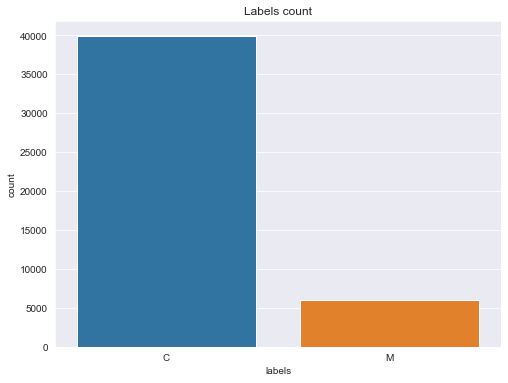

In [8]:
#Is the dataset balanced?
plt.figure(figsize=(8, 6))  # set plot size
ax = sb.countplot(x="labels", data=data)
ax.set_title("Labels count")

The plot shows that our data is unbalanced. We get around 40000 rows for Chirac versus 6000 rows for Mitterrand. 
We have to take into consideration this point when splitting the data.

#### 2- Words count

Text(0.5, 1.0, 'Word count foreach president')

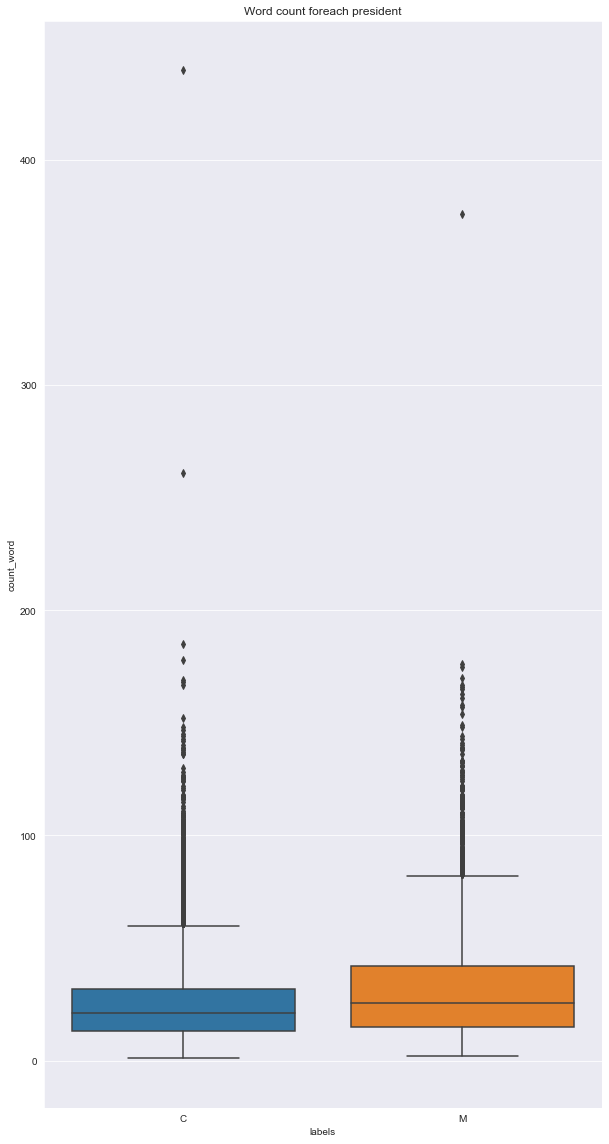

In [9]:
plt.figure(figsize=(10, 20))  # set plot size
ax = sb.boxplot(x="labels", y="count_word", data=data)
ax.set_title("Word count foreach president")

Overall, Mitterand use longer sentences. As average, the sentence length is 31 word for Mitterand and 24 for Chirac.

#### 3- Most used words

In [10]:
data.head()

,sentences,labels,clean_sentences,non_stopWords,count_word,count_non_stopWords
0,J'aurai l'occasion de dire aux Français commen...,C,j aurai l occasion de dire aux français commen...,occasion dire français enseignement devra évol...,59,23
1,Il est nécessaire.,C,il est nécessaire,nécessaire,3,1
2,"Dans votre coeur et dans votre vie, la confian...",C,dans votre coeur et dans votre vie la confian...,coeur vie confiance enthousiasme emportent doute,18,6
3,Pour conduire ce débat dans un esprit de vérit...,C,pour conduire ce débat dans un esprit de vérit...,conduire débat esprit véritable dialogue compt...,59,27
4,La France et l'Europe construiront ainsi un av...,C,la france et l europe construiront ainsi un av...,france europe construiront ainsi avenir coopér...,34,16


#####  a- all words

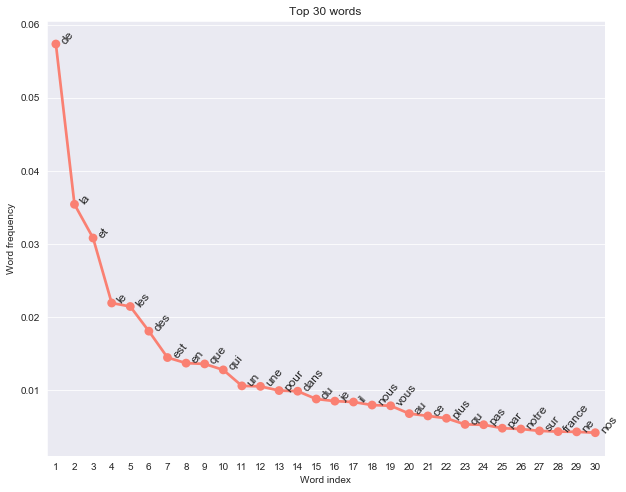

In [11]:
top_30_words = get_top_n_words(data["clean_sentences"], n=30) # get top 30 words with their frequency
top_30_words_words = [elt[0] for elt in top_30_words]
top_30_words_freq = [elt[1] for elt in top_30_words]
# plot the graph
plot_word_freq(top_30_words_words, top_30_words_freq, "Top 30 words", adjx=0.2, c="salmon")

We start by looking at the presence of words in all the documents. We see in the figure above that stop words dominate.
Let's do the same plot after removing this words.

##### b- remove stopwords

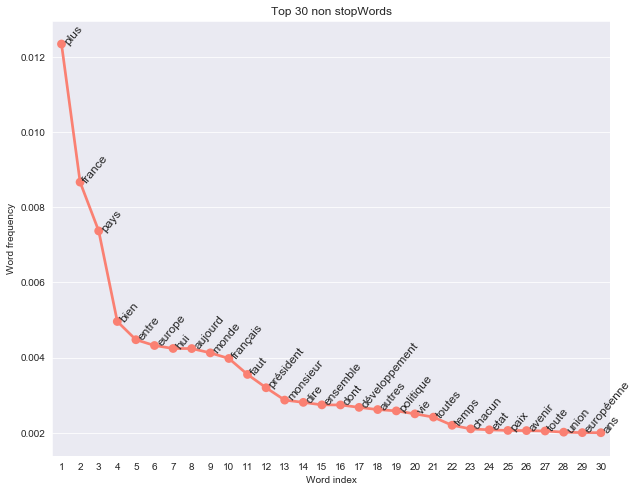

In [12]:
top_30_words = get_top_n_words(data["non_stopWords"], n=30) # get top 3O non stop words and their frequency
top_30_words_words = [elt[0] for elt in top_30_words]
top_30_words_freq = [elt[1] for elt in top_30_words]
plot_word_freq(words=top_30_words_words, freq=top_30_words_freq, title="Top 30 non stopWords", n=30, \
               adjx=0.05, adjy=-0.000009, c="salmon")

We can see clearly that the frequency of words is very different after removing the stop words.   
The top 30 words can be easly finded in any french politician speech.  
Let's do a comparaison between most used words for Chirac and for Mitterrand.

###### c- Most used words per president

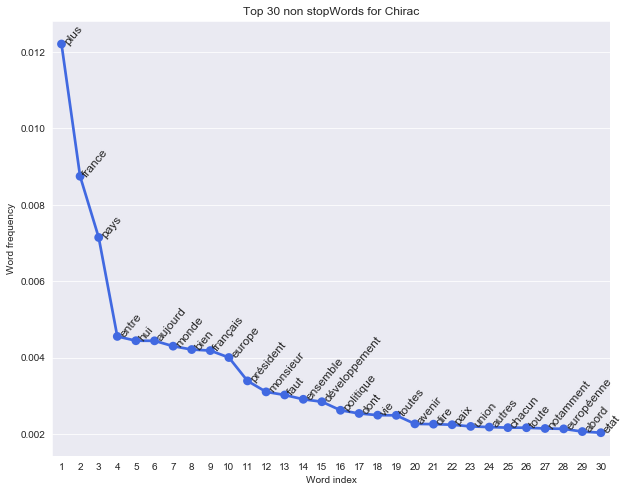

In [13]:
C_data = data[data["labels"] == 'C']  # get Chirac data
top_30_words = get_top_n_words(C_data["non_stopWords"], n=30) # get top 3O non stop words and their frequency
top_30_words_words = [elt[0] for elt in top_30_words]
top_30_words_freq = [elt[1] for elt in top_30_words]
plot_word_freq(words=top_30_words_words, freq=top_30_words_freq, title="Top 30 non stopWords for Chirac", n=30, \
               adjx=0.05, adjy=-0.000009, c="royalblue")

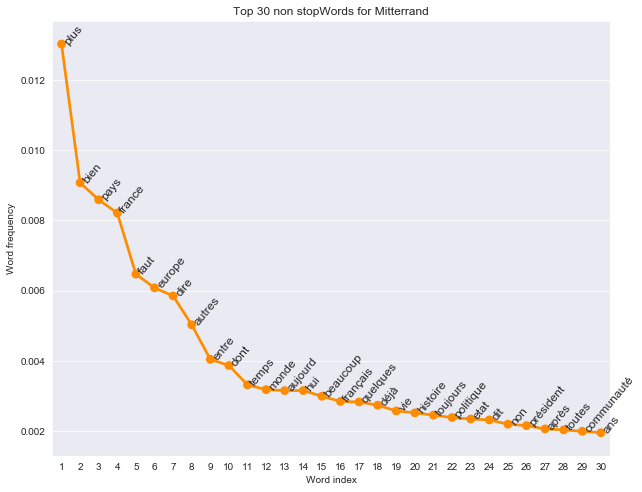

In [14]:
M_data = data[data["labels"] == 'M']  # get Chirac data
top_30_words = get_top_n_words(M_data["non_stopWords"], n=30) # get top 3O non stop words and their frequency
top_30_words_words = [elt[0] for elt in top_30_words]
top_30_words_freq = [elt[1] for elt in top_30_words]
plot_word_freq(words=top_30_words_words, freq=top_30_words_freq, title="Top 30 non stopWords for Mitterrand", n=30, \
               adjx=0.05, adjy=-0.000009)

We see that "top 30 Chirac" words is nearer to the "all top 30 words" than Mitterrand. We can explain this by the fact of data unbalancy between the two presidents.  
Secondly, the most used words for the two presidents are very similar (ex: france, europe, président). It was expected because Chirac is Mitterrand successor (president of the same nation).    
Finally: the words "développement" and "paix" are very used by Chirac but not by Mitterrand. In the opposite side, words like "histoire" and "communauté" are very used by Mitterrrand but not by Chirac. It is probably due to the diffence of ideology (Chirac: droite, Mitterrand: gauche). Another reason, during Chirac presidential term, France didn't have the same priorities as during Mitterrand term (like wars on terrorism).    
The last remark give us the idea to search for the words used only by Chirac (respectively Mitterrand).

#### 4- Exclusive  words

In [15]:
# get all the words for Chirac
all_c_words = get_top_n_words(C_data["non_stopWords"], n=C_data.shape[0])
all_c_words_words = [elt[0] for elt in all_c_words]
# get all the words for Mitterrand
all_m_words = get_top_n_words(M_data["non_stopWords"], n=M_data.shape[0])
all_m_words_words = [elt[0] for elt in all_m_words]
# get exclusive words for Chirac
excl_words_c = [word for word in all_c_words if word[0] not in all_m_words_words]
# get exclusive words for Mitterrand
excl_words_m = [word for word in all_m_words if word[0] not in all_c_words_words]

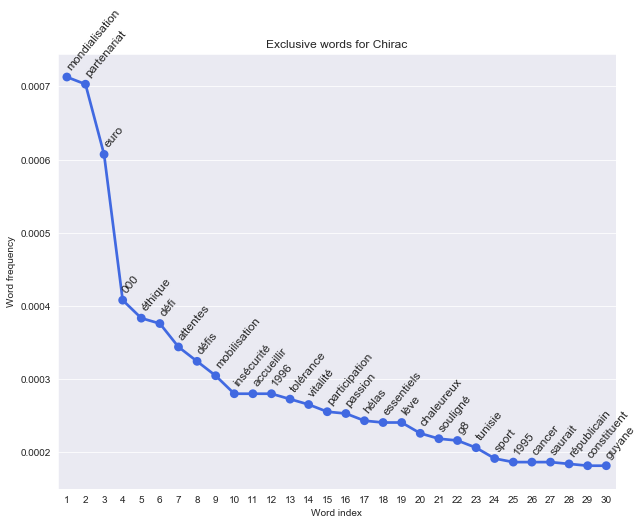

In [16]:
#Exclusive words Chirac plot
excl_words_c_words = [elt[0] for elt in excl_words_c][:30]
excl_words_c_freq = [elt[1] for elt in excl_words_c][:30]
plot_word_freq(words=excl_words_c_words, freq=excl_words_c_freq, title="Exclusive words for Chirac", n=30, \
               adjx=-0.1, adjy=0.00001, c="royalblue")

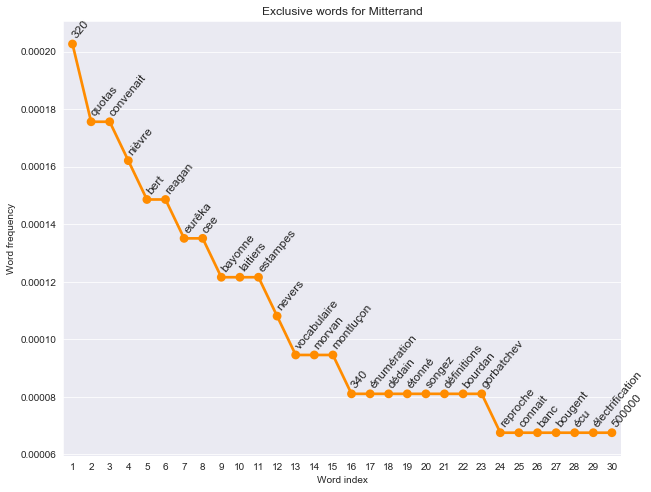

In [17]:
#Exclusive words Mitterrand plot
excl_words_m_words = [elt[0] for elt in excl_words_m][:30]
excl_words_m_freq = [elt[1] for elt in excl_words_m][:30]
plot_word_freq(words=excl_words_m_words, freq=excl_words_m_freq, title="Exclusive words for Mitterrand", n=30, \
               adjx=-0.1, adjy=0.000002)

By comparing the two plots, we observe many interesting points in relation with the events for each president political life:
1. For Chirac:
    - Euro became the official currency of France in Chirac presidential term (words: euro and mondialisation).
    - Russia joined the G7 so it became the G8 (word: g8).
    - Chirac was elected president in 1995 (word: 1995).
    - He was part of Rally for the Republic (word: républicain).      
<br>
2. For Mitterrand
    - He won a seat as deputy from Nièvre (word: nièvre).
    - He collaborated with Ronald Reagan for Farewell case (word: reagan).
    - EUREKA was established by Mitterrand (word: eurêka).
    - He was the mayor of Château-Chinon (word: morvan).

### IV- Splitting Data

In [18]:
data.head()

,sentences,labels,clean_sentences,non_stopWords,count_word,count_non_stopWords
0,J'aurai l'occasion de dire aux Français commen...,C,j aurai l occasion de dire aux français commen...,occasion dire français enseignement devra évol...,59,23
1,Il est nécessaire.,C,il est nécessaire,nécessaire,3,1
2,"Dans votre coeur et dans votre vie, la confian...",C,dans votre coeur et dans votre vie la confian...,coeur vie confiance enthousiasme emportent doute,18,6
3,Pour conduire ce débat dans un esprit de vérit...,C,pour conduire ce débat dans un esprit de vérit...,conduire débat esprit véritable dialogue compt...,59,27
4,La France et l'Europe construiront ainsi un av...,C,la france et l europe construiront ainsi un av...,france europe construiront ainsi avenir coopér...,34,16


In [19]:
# convert lables 'C' and 'M' to int values (0 and 1)
data['labelNum']= data.labels.map({'C':0, 'M':1})
#split X and y into train and test data 80% and 20%
#parametre stratify ensure to have the same labels distribution in train and test data
#random_state is fixed to 1 in order to have the same split foreach execution
X_train, X_test, y_train, y_test = train_test_split(data["sentences"], data['labelNum'], test_size = 0.2,\
                                                   stratify=data['labelNum'], random_state=1)

### V- Text representation

#### 1- TF_IDF + LR

In [20]:
# create pipeline (tf_idf and Logistic regression)
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])
print("Pipeline created")

# gridsearch to tune the model
param_grid = { 
    'logreg__C' : [50],         #[0.1, 1, 10,20, 50, 80, 1e2]
    'logreg__penalty' : ['l1'],  #['l1', 'l2']
    'logreg__class_weight' : ['balanced'],
    'logreg__max_iter': [1000],
    'tfidf__stop_words' : [stopWords],
    'tfidf__max_df': [.8],       #[.2, .5, .7, .8, 1]
    'tfidf__min_df': [1],        #[0, 3, 5, 10, 20, 30]
    'tfidf__tokenizer' : [tokenizer_stemmer],
    'tfidf__ngram_range': [(1, 3)]
 }
print("Parameters combination setted up")


grid = GridSearchCV(clf, cv=5, param_grid=param_grid, return_train_score=True, scoring = 'f1', verbose=1, n_jobs=-1)
print("GridSeach configuration setted up")

#fit the model
grid.fit(X_train,y_train)
print("Model fitted")

Pipeline created
Parameters combination setted up
GridSeach configuration setted up
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 129.6min remaining: 194.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 138.3min finished
C:\Users\chenb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model fitted


C:\Users\chenb\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [21]:
#plot_param_effect(grid=grid, param="param_logreg__C", title="Effect of regularization (C)")

In [22]:
grid.best_score_

0.5056640661086176

Test set predicted
              precision    recall  f1-score   support

      Chirac       0.94      0.89      0.91      7982
  Mitterrand       0.45      0.63      0.53      1204

    accuracy                           0.85      9186
   macro avg       0.70      0.76      0.72      9186
weighted avg       0.88      0.85      0.86      9186

[[7069  913]
 [ 446  758]]


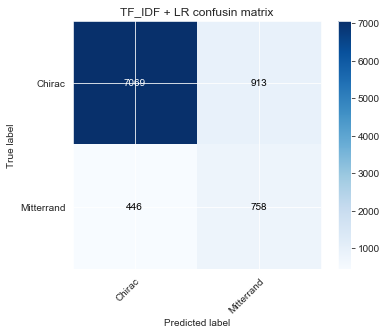

In [23]:
y_pred = grid.predict(X_test)
print("Test set predicted")

#show classification report
target_names = ['Chirac', 'Mitterrand']
print(classification_report(y_test, y_pred, target_names=target_names))

#show confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=False, title="TF_IDF + LR confusin matrix",
                      classes=target_names)

#### 2- TF_IDF + SVM

In [24]:
# create pipeline (tf_idf and SVM)
clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC())
])
print("Pipeline created")

# gridsearch to tune the model
param_grid = { 
    'svm__C' : [1],       #[.1, 1, 10]
    'svm__gamma' : [.001],  #[.001, .01, .1, 1, 10]
    'svm__kernel' : ['linear', 'rbf'],    #['linear', 'rbf']
    'svm__class_weight' : ['balanced'],
    'tfidf__stop_words' : [stopWords],
    'tfidf__max_df': [.8],       #[.2, .5, .7, .8, 1]
    'tfidf__min_df': [1],        #[0, 3, 5, 10, 20, 30]
    'tfidf__tokenizer' : [tokenizer_stemmer],
    'tfidf__ngram_range': [(1, 3)]
 }
print("Parameters combination setted up")


grid_svm = GridSearchCV(clf, cv=5, param_grid=param_grid, return_train_score=True, scoring = 'f1', verbose=1, n_jobs=-1)
print("GridSeach configuration setted up")

#fit the model
grid_svm.fit(X_train,y_train)
print("Model fitted")

Pipeline created
Parameters combination setted up
GridSeach configuration setted up
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 17.2min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 23.8min finished


Model fitted


In [25]:
grid_svm.best_score_

0.5365714675534765

Test set predicted
              precision    recall  f1-score   support

      Chirac       0.94      0.93      0.93      7982
  Mitterrand       0.55      0.59      0.57      1204

    accuracy                           0.88      9186
   macro avg       0.74      0.76      0.75      9186
weighted avg       0.89      0.88      0.88      9186

[[7395  587]
 [ 490  714]]


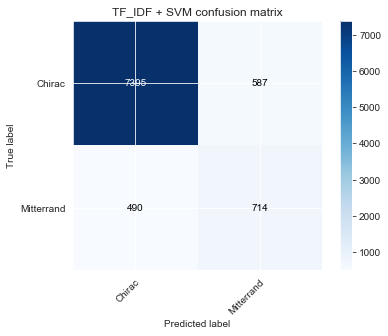

In [26]:
y_pred_svm = grid_svm.predict(X_test)
print("Test set predicted")

#show classification report
target_names = ['Chirac', 'Mitterrand']
print(classification_report(y_test, y_pred_svm, target_names=target_names))

#show confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, normalize=False, title="TF_IDF + SVM confusion matrix",
                      classes=target_names)

#### 3- Word2Vec + LR

In [27]:
# Import pre trained word2vec model
filename = "Data/pre_trained W2V/embed_tweets_fr_300M_52D"
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [28]:
print("taille de Vocab" ,len(word2vec.vocab))
print("dimension ",len(word2vec.word_vec(word='président')))

taille de Vocab 2880086
dimension  52


In [29]:
# create pipeline (word2vec and LR)
w2v_logreg = Pipeline([
            ('w2v', word2vec_transformer(word2vec, 52)),
            ('logreg', LogisticRegression())
])
print("Pipeline created")

# gridsearch to tune the model
param_grid = { 
    'logreg__C' : [1],               #[0.1, 1, 10]
    'logreg__penalty' : ['l2'],
    'logreg__class_weight' : ['balanced'],
    'logreg__max_iter': [1000]
}
print("Parameters combination setted up")


grid_w2v_lr = GridSearchCV(w2v_logreg, cv=5, param_grid=param_grid, return_train_score=True, scoring = 'f1', 
                           verbose=1, n_jobs=-1)
print("GridSeach configuration setted up")

#fit the model
grid_w2v_lr.fit(X_train,y_train)
print("Model fitted")


Pipeline created
Parameters combination setted up
GridSeach configuration setted up
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\chenb\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.6min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.1min finished


word2vec transformation ...
word2vec transformation finish


C:\Users\chenb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model fitted


In [30]:
grid_w2v_lr.best_params_

{'logreg__C': 1,
 'logreg__class_weight': 'balanced',
 'logreg__max_iter': 1000,
 'logreg__penalty': 'l2'}

In [31]:
grid_w2v_lr.best_score_

0.3519457842819943

word2vec transformation ...
word2vec transformation finish
Test set predicted
              precision    recall  f1-score   support

      Chirac       0.93      0.68      0.79      7982
  Mitterrand       0.24      0.69      0.36      1204

    accuracy                           0.68      9186
   macro avg       0.59      0.68      0.57      9186
weighted avg       0.84      0.68      0.73      9186

[[5415 2567]
 [ 377  827]]


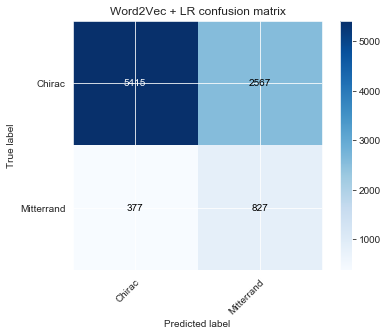

In [32]:
y_pred_w2v_lr = grid_w2v_lr.predict(X_test)
print("Test set predicted")

#show classification report
target_names = ['Chirac', 'Mitterrand']
print(classification_report(y_test, y_pred_w2v_lr, target_names=target_names))

#show confusion matrix
plot_confusion_matrix(y_test, y_pred_w2v_lr, normalize=False, title="Word2Vec + LR confusion matrix",
                      classes=target_names)

#### 4- Word2Vec + SVM

In [33]:
# create pipeline (word2vec and LR)
w2v_svm = Pipeline([
            ('w2v', word2vec_transformer(word2vec, 52)),
            ('svm', SVC())
])
print("Pipeline created")

# gridsearch to tune the model
param_grid = { 
    'svm__C' : [1],        #[.1, 1]
    'svm__gamma' : [1],    #[.1, 1]
    'svm__kernel' : ['rbf'],      #['rbf', 'linear']
    'svm__class_weight' : ['balanced']
}
print("Parameters combination setted up")


grid_w2v_svm = GridSearchCV(w2v_svm, cv=5, param_grid=param_grid, return_train_score=True, scoring = 'f1', 
                           verbose=1, n_jobs=-1)
print("GridSeach configuration setted up")

#fit the model
grid_w2v_svm.fit(X_train,y_train)
print("Model fitted")


Pipeline created
Parameters combination setted up
GridSeach configuration setted up
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\chenb\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.8min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.5min finished


word2vec transformation ...
word2vec transformation finish
Model fitted


In [34]:
grid_w2v_svm.best_params_

{'svm__C': 1,
 'svm__class_weight': 'balanced',
 'svm__gamma': 1,
 'svm__kernel': 'rbf'}

In [35]:
grid_w2v_svm.best_score_

0.3829272390277031

word2vec transformation ...
word2vec transformation finish
Test set predicted
              precision    recall  f1-score   support

      Chirac       0.94      0.73      0.82      7982
  Mitterrand       0.28      0.70      0.40      1204

    accuracy                           0.72      9186
   macro avg       0.61      0.71      0.61      9186
weighted avg       0.85      0.72      0.77      9186

[[5808 2174]
 [ 364  840]]


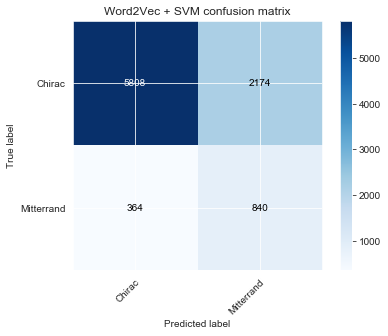

In [36]:
y_pred_w2v_svm = grid_w2v_svm.predict(X_test)
print("Test set predicted")

#show classification report
target_names = ['Chirac', 'Mitterrand']
print(classification_report(y_test, y_pred_w2v_svm, target_names=target_names))

#show confusion matrix
plot_confusion_matrix(y_test, y_pred_w2v_svm, normalize=False, title="Word2Vec + SVM confusion matrix",
                      classes=target_names)

#### 4- Models combination

In [57]:
# tf_idf+lr, tf_idf+svm and w2v+svm combination
y_combo = y_pred + y_pred_svm + y_pred_w2v_svm
y_vote = [voters(x) for x in y_combo] # convert to 0 (Chirac) or 1 (Mitterrand)

              precision    recall  f1-score   support

      Chirac       0.94      0.91      0.93      7982
  Mitterrand       0.51      0.63      0.57      1204

    accuracy                           0.87      9186
   macro avg       0.73      0.77      0.75      9186
weighted avg       0.89      0.87      0.88      9186

[[7255  727]
 [ 441  763]]


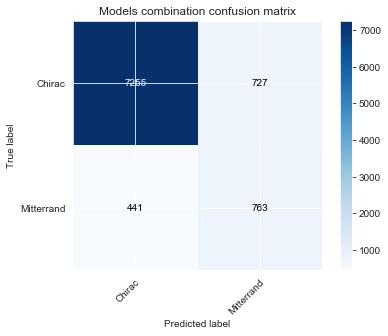

In [58]:
#show classification report
target_names = ['Chirac', 'Mitterrand']
print(classification_report(y_test, y_vote, target_names=target_names))

#show confusion matrix
plot_confusion_matrix(y_test, y_vote, normalize=False, title="Models combination confusion matrix",
                      classes=target_names)